# Predicting Openness Personality Trait using Facebook Updates

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer

import importlib

import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')  # HD Plots

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp drive/MyDrive/data/data.py .
!cp drive/MyDrive/data/models.py .
!cp drive/MyDrive/data/train_eval.py .
!cp drive/MyDrive/data/mypersonality_final.csv .

In [6]:
# ! pip install langdetect

In [7]:
import data
import models
import train_eval

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Prepare data

In [56]:
# path = "./mypersonality_final/mypersonality_final.csv"
path = "./mypersonality_final.csv"
df = pd.read_csv(path, encoding='latin1')

X = df['STATUS'].apply(data.clean_text).values
y = [1 if label == 'y' else 0 for label in df['cOPN'].values]

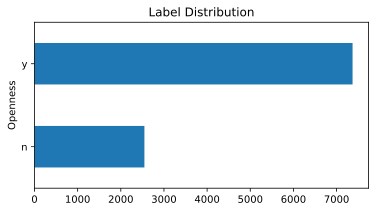

In [57]:
plt.subplots(figsize=(6, 3))
df['cOPN'].value_counts(ascending=True).plot.barh()
plt.title('Label Distribution')
plt.ylabel("Openness")
plt.show()

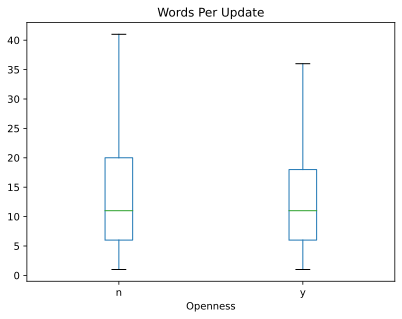

In [58]:
df['Words Per Update'] = df['STATUS'].str.split().apply(len)
df.boxplot('Words Per Update', by='cOPN', grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("Openness")
plt.show()

In [59]:
X_val_train, X_test, y_val_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_val_train, y_val_train, test_size=0.25, random_state=42)

In [60]:
print(f"Text: '{X_train[0]}'")
print(f"Label: {y_train[0]}")

Text: 'propname spice life apparently one signature strengths help make life adventurous today thank lord making salt light'
Label: 1


In [61]:
X_train_sub, y_train_sub = data.drop_short_and_too_long_texts(X_train, y_train)
X_train_sub, y_train_sub = data.drop_non_english_texts(X_train_sub, y_train_sub)

X_val_sub, y_val_sub = data.drop_short_and_too_long_texts(X_valid, y_valid)
X_val_sub, y_val_sub = data.drop_non_english_texts(X_val_sub, y_val_sub)

X_test_sub, y_test_sub = data.drop_short_and_too_long_texts(X_test, y_test)
X_test_sub, y_test_sub = data.drop_non_english_texts(X_test_sub, y_test_sub)

In [62]:
print("Train:")
print(len(X_train), len(y_train))
print(len(X_train_sub), len(y_train_sub))

print("\nValid:")
print(len(X_valid), len(y_valid))
print(len(X_val_sub), len(y_val_sub))

print("\nTest:")
print(len(X_test), len(y_test))
print(len(X_test_sub), len(y_test_sub))

Train:
5949 5949
3598 3598

Valid:
1984 1984
1155 1155

Test:
1984 1984
1195 1195


In [63]:
# Get our tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [64]:
print('The vocabulary size is:', tokenizer.vocab_size)
print('Maximum context size:', tokenizer.model_max_length)
print('Name of the fields, model need in the forward pass:', tokenizer.model_input_names)

The vocabulary size is: 30522
Maximum context size: 512
Name of the fields, model need in the forward pass: ['input_ids', 'attention_mask']


In [65]:
# Encode X_train, X_valid, X_test
X_train_ids, X_train_attention = data.batch_encode(tokenizer, X_train_sub)
X_valid_ids, X_valid_attention = data.batch_encode(tokenizer, X_val_sub)
X_test_ids, X_test_attention = data.batch_encode(tokenizer, X_test_sub)

In [66]:
train_ds = data.PersonalityDataset(X_train_ids, X_train_attention, y_train_sub)
valid_ds = data.PersonalityDataset(X_valid_ids, X_valid_attention, y_val_sub)
test_ds = data.PersonalityDataset(X_test_ids, X_test_attention, y_test_sub)

In [67]:
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Train a Classifier using distilBERT Embeddings

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.BERTClassifier(num_labels=1).to(device)

optimizer = Adam(model.classifier.parameters(), lr=0.00002)
loss_fn = nn.BCEWithLogitsLoss()

# Start training and evaluation
train_loss, val_loss, val_acc = train_eval.train_and_evaluate(
    model, train_loader, valid_loader, loss_fn, optimizer, device, epochs=5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/5, Train Loss: 0.6613, Val Loss: 0.6482, Val Acc: 0.7166


Epoch 2/5, Train Loss: 0.6246, Val Loss: 0.6251, Val Acc: 0.7166


Epoch 3/5, Train Loss: 0.6034, Val Loss: 0.6141, Val Acc: 0.7166


Epoch 4/5, Train Loss: 0.5941, Val Loss: 0.6096, Val Acc: 0.7166


Epoch 5/5, Train Loss: 0.5874, Val Loss: 0.6080, Val Acc: 0.7166


In [32]:
accuracy, precision, recall, f1 = train_eval.evaluate_performance(model, test_loader, device)


print("\nTest metrics:")
print(f"""
accuracy: {round(accuracy*100,2)}%
precision: {round(precision*100,2)}%
recall: {round(recall*100,2)}%
f1: {round(f1*100,2)}%
      """)


Test metrics:

accuracy: 74.54%
precision: 74.54%
recall: 100.0%
f1: 85.41%
      


# Finetune distilBERT as a Classifier

In [72]:
class BERTClassifierUnfrozen(nn.Module):
    def __init__(self, num_labels=1):
        super().__init__()
        self.distilBERT = AutoModel.from_pretrained("distilbert-base-uncased")

        for param in self.distilBERT.parameters():
            param.requires_grad = True

        self.classifier = nn.Linear(self.distilBERT.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.distilBERT(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]
        logits = self.classifier(hidden_state)
        return logits


In [78]:
m2 = BERTClassifierUnfrozen().to(device)

In [79]:
params_to_update = []
for param_name, param in m2.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        # print(f"Params to train: {param_name}")

optimizer_2 = Adam(params_to_update, lr=0.00002)

In [80]:
train_loss, val_loss, val_acc = train_eval.train_and_evaluate(
    m2, train_loader, valid_loader, loss_fn, optimizer_2, device, epochs=10)

Epoch 1/10, Train Loss: 0.7206, Val Loss: 0.6897, Val Acc: 0.5437


Epoch 2/10, Train Loss: 0.6654, Val Loss: 0.6492, Val Acc: 0.7160


Epoch 3/10, Train Loss: 0.6316, Val Loss: 0.6257, Val Acc: 0.7160


Epoch 4/10, Train Loss: 0.6092, Val Loss: 0.6133, Val Acc: 0.7160


Epoch 5/10, Train Loss: 0.5969, Val Loss: 0.6070, Val Acc: 0.7160


Epoch 6/10, Train Loss: 0.5913, Val Loss: 0.6041, Val Acc: 0.7160


Epoch 7/10, Train Loss: 0.5871, Val Loss: 0.6030, Val Acc: 0.7160


Epoch 8/10, Train Loss: 0.5851, Val Loss: 0.6027, Val Acc: 0.7160


Epoch 9/10, Train Loss: 0.5847, Val Loss: 0.6026, Val Acc: 0.7160


Epoch 10/10, Train Loss: 0.5834, Val Loss: 0.6025, Val Acc: 0.7160


In [81]:
accuracy, precision, recall, f1 = train_eval.evaluate_performance(m2, test_loader, device)


print("\nTest metrics:")
print(f"""
accuracy: {round(accuracy*100,2)}%
precision: {round(precision*100,2)}%
recall: {round(recall*100,2)}%
f1: {round(f1*100,2)}%
      """)


Test metrics:

accuracy: 74.64%
precision: 74.64%
recall: 100.0%
f1: 85.48%
      


In [82]:
accuracy, precision, recall, f1 = train_eval.evaluate_performance(m2, train_loader, device)


print("\nTest metrics:")
print(f"""
accuracy: {round(accuracy*100,2)}%
precision: {round(precision*100,2)}%
recall: {round(recall*100,2)}%
f1: {round(f1*100,2)}%
      """)


Test metrics:

accuracy: 73.49%
precision: 73.49%
recall: 100.0%
f1: 84.72%
      
